<a href="https://colab.research.google.com/github/apapaioannou92/BA/blob/HW2/aap2204_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IEOR 4650  Business Analytics (Fall 2019)**

**Homework 2 [Total points: 60]**

** Due: 11:59 PM, October 8**

This second homework consists of Python programming practices and the applications to linear regression. 

The steps to finish in the homework:

*   Step 1: Make a copy of the file to your LionDrive.
*   Step 2: Work with the copy (an ipynb file).
*    <font color='red'>**Step 3: Rename the copy to your_uni_hw2.ipynb (For example: yd4501_hw2.ipynb).**</font>  
*   Step 4: Submit the copy on CourseWorks.

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)


**All the questions in this homework requires coding**

In [0]:
#This imports all the packages you need for the homework
#Please run this first


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#import modules

import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt




##Setting
In this exercise, let's continue working with a dataset which explores the store sales.

Before doing the assignment, please study this dataset here https://www.kaggle.com/c/rossmann-store-sales/data


For this study, we are interested in finding a good model that gives good prediction performance. 

* Especially, we are interested in use RMSPE as our accuracy measurement. RMSPE is defined as following:
$$RMSPE = \sqrt{\frac{\frac{(y_i-\widehat{y_i}}{y_i})^2}{N}}$$
* In addition, any day and store with 0 actual sales is ignored in scoring.

In [131]:
#Load the dataset
link="https://drive.google.com/open?id=1Q6J0q4tlWJ7TajX6hMSvZ8tK3CyDD8QY"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Sales.csv')  
SALE = pd.read_csv('Sales.csv')
SALE.head(5)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


*You might see a warning when importing the data. This is because StateHoliday has both values in string and numbers. No worries this for now.*

In [132]:
link="https://drive.google.com/open?id=1g6URzUJnhCLOtg0a9TTHC18KYcqwxvoc"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile_store.csv')  
STORE = pd.read_csv('myfile_store.csv')
STORE.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Q1. [8 points]
**[Data Cleaning]**

1. Merge two tables based on "Store" column

2. To save you from the pain of running the models for too long, **keep only records for store 1-100**.

3. This study only cares about the accuracy performend on the data with Sales higher than 0.There are pros and cons of keeping 0 Sales records. For this study, let's **delete all the sales records with sales=0**.

4. Print out the unique values you have in "StateHoliday" column. If you see anything that goes wrong, fix the issue. After that, print out the unique values again in "StateHoliday" column. [You might find this [link](https://www.geeksforgeeks.org/python-pandas-series-str-replace-to-replace-text-in-a-series/) useful]


In [133]:
# Merging the Sales and Store dfs

Sales_Store_merged = SALE.merge(STORE, on = "Store", how='left') # since Store is the only 1 common column in both dfs

# Store = STORE[:99]
Filter_ = (Sales_Store_merged['Store'].isin(range(1,101))) & (Sales_Store_merged['Sales']!=0)
# Store.head(5)

# Reloading the initial Sales dataset into a df

Sales_Store_merged = Sales_Store_merged[Filter_]
# Sales.head()

# Sales_Store_merged.head()

Sales_Store_merged['StateHoliday'].unique()

# We observe that 0 appears as a string object but also as an integer object. Sales is a categorical feature, so we will replace the 0 (integer value of 0) with the string '0'

# Overwriting column with replaced value of age 
Sales_Store_merged['StateHoliday'] = Sales_Store_merged['StateHoliday'].replace(0, '0') 

Sales_Store_merged['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [134]:
Sales_Store_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Q2 [4 points]

**[Preparation for cross-validation]**

Split our data into three segments.Instead of shuffling them first, we will do something different. When working with prediction, we might want to have a model that can give good prediction power for the future sales. Thus, we will split our data in the following way:

(1) Training: Time window 2013-01-01 to 2015-03-31  

(2) Validation: Time window 2015-04-01 to 2015-05-31 

(3) Testing: Time window 2015-06-01 to 2015-07-31

Print out how many records you have for each set.

In [135]:
#You might find the following sample code helpful 
#X=X.astype({"Date":"datetime64"})
#X["Date"]<"2015-01-02"

# We make sure we tranform the type of the Sales_Store_merged['Date'] column from string to datatime64 object type 
Sales_Store_merged = Sales_Store_merged.astype({"Date":"datetime64"})

# We create the training set 
Sales_Store_merged_training = Sales_Store_merged[((Sales_Store_merged['Date'] >= "2013-01-01") & (Sales_Store_merged['Date'] <= "2015-03-31"))]
Sales_Store_merged_training.head()

# We create the validation set 
Sales_Store_merged_validation = Sales_Store_merged[((Sales_Store_merged['Date'] >= "2015-04-01") & (Sales_Store_merged['Date'] <= "2015-05-31"))]

# We create the testing set 
Sales_Store_merged_testing = Sales_Store_merged[((Sales_Store_merged['Date'] >= "2015-06-01") & (Sales_Store_merged['Date'] <= "2015-07-31"))]

print( len(Sales_Store_merged_training), len(Sales_Store_merged_validation), len(Sales_Store_merged_testing) )

65631 4715 5245


##Q3 [8 points]

**[Feature Engineering 1 ]**

Usually, people pay great attention to the features that are highly predictive. Making sure that adequate variable transformations are performed on those variables are highly important. 

* Examine why customer numbers is an important predictor based on the data.

* Use 4 histograms show how taking the log-transformation changes the distribution of "Sales" and "Customers" on the training set. Make layout the 4 histograms following the following format

\begin{bmatrix}
    \text{Sales plot here} &  \text{log(Sales) plot here} \\
    \text{Customer plot here} &  \text{log(Customer) plot here}
\end{bmatrix}.

>You will find this [link](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html) useful

2. 
  Based on cross-validation to show which model gives a better performance. 
  $$log(Sales)=\beta_0+\beta_1 log(Customers)+\epsilon$$ 
  $$Sales=\beta_0+\beta_1 Customers+\epsilon$$ 


              Sales  Customers
Sales      1.000000   0.832475
Customers  0.832475   1.000000


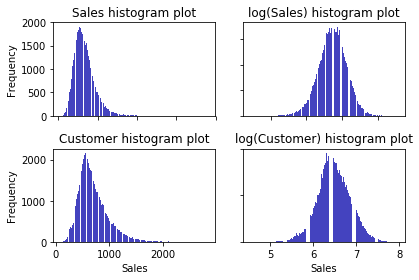

In [136]:
# correlation

Sales_Store_merged_ = Sales_Store_merged[['Sales', 'Customers']]

correlation_ = Sales_Store_merged_.corr(method = 'pearson')

print(correlation_)

# Customer numbers is an important predictor based on the data because its correlation with the target variable named Sales is high (83%) 

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(x=Sales_Store_merged_training['Sales'], bins='auto', color='#0504aa',
                            alpha=0.75, rwidth=0.85)
axs[0, 0].set_title('Sales histogram plot')
axs[0, 1].hist(x=np.log(Sales_Store_merged_training['Sales']), bins='auto', color='#0504aa',
                            alpha=0.75, rwidth=0.85)
axs[0, 1].set_title('log(Sales) histogram plot')
axs[1, 0].hist(x=Sales_Store_merged_training['Customers'], bins='auto', color='#0504aa',
                            alpha=0.75, rwidth=0.85)
axs[1, 0].set_title('Customer histogram plot')
axs[1, 1].hist(x=np.log(Sales_Store_merged_training['Customers']), bins= 'auto', color='#0504aa',
                            alpha=0.75, rwidth=0.85)

axs[1, 1].set_title('log(Customer) histogram plot')

for ax in axs.flat:
    ax.set(xlabel='Sales', ylabel='Frequency')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()

In [137]:
#Model training on the training set
model1=ols(formula="Sales~Customers", data=Sales_Store_merged_training).fit()
model2=ols(formula="np.log(Sales)~np.log(Customers)", data=Sales_Store_merged_training).fit()

print(model1.summary())
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                 1.523e+05
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        06:17:27   Log-Likelihood:            -5.6991e+05
No. Observations:               65631   AIC:                         1.140e+06
Df Residuals:                   65629   BIC:                         1.140e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1115.5926     15.234     73.230      0.0

In [138]:
#Selecting the best model based the validation set

##First, get the predicted value 
Prediction1=model1.predict(Sales_Store_merged_validation)
###Model 2 took used log transformation on the dependent variable
###Need to exponentiate the predicted value 
Prediction2=np.exp(model2.predict(Sales_Store_merged_validation))

def rmse(predictions, targets):
    return np.sqrt( ( (predictions - targets) ** 2 ).mean() )

def rmspe(predictions, targets):
  # (np.mean(((predictions-targets)/targets)**2))**0.5
    return np.sqrt( ( ( (predictions - targets)/targets) ** 2).mean() )

##Second, get the RMSPE and RMSE

Actual=Sales_Store_merged_validation["Sales"]
RMSPE1=rmspe(Prediction1, Actual)
RMSPE2=rmspe(Prediction2, Actual)

RMSE1=rmse(Prediction1, Actual)
RMSE2=rmse(Prediction2, Actual)

print(RMSPE1,RMSPE2)
print(RMSE1,RMSE2)

# The RMSPE is a more trustworthy measure to capture the accuracy of a regression model. So, based on the RMSPE value of the 2 models, we conclude that the 
# the 2nd model has a better performance (= has higher predictive power), since its RMSPE is lower, ie RMSPE2=0.193<RMSPE1=0.200.

0.20039447823717005 0.19366408523982762
1497.3942814659956 1513.855766422655


##Q4 [7 points]

**[Feature Engineering 2]**

In the business operation, stores performance can vary with time. Including the time/date information can potentially help us increase the model fit. Some typical factors we can consider are:

* Year [store performance in 1992 can be different from the performance in 2010]
* Month [For example, an ice-cream shop generally have higher sales in the summer months]
* Day of the week [Especially, weekend v.s. weekdays might show very differen performances]
* Important events

In our dataset, we have "DayOfWeek", "SchoolHoliday" and "StateHoliday" to capture the last two factors. However, we do not have the "Year" and "Month".

Luckily, once we specify "Date" as the datetime type. We can easily extract the time information. See the link [here](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetimelike-properties)

For Q4: Do the following 

* Argue the pros and cons of adding Month as a categorical variable v.s. continuous variable.
* Determine the best decision using cross-validation.


In [139]:
#Suppose x3 is a datetype column. If you want to get year information and treat it as a continuous variable in the regression, you can simply do
#("y~x1+x2+x3.dt.month",data=Data)
model3=ols(formula="np.log(Sales)~np.log(Customers)+Date.dt.month", data=Sales_Store_merged_training).fit()
print(model3.summary())

model4=ols(formula="np.log(Sales)~np.log(Customers)+C(Date.dt.month)", data=Sales_Store_merged_training).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Sales)   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                 9.016e+04
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        06:17:27   Log-Likelihood:                 12648.
No. Observations:               65631   AIC:                        -2.529e+04
Df Residuals:                   65628   BIC:                        -2.526e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.0511      0.01

In [140]:
#Selecting the best model based the validation set

##First, get the predicted value 

###Model 3 took used log transformation on the dependent variable
###Need to exponentiate the predicted value 
Prediction3=np.exp(model3.predict(Sales_Store_merged_validation))

###Model 4 took used log transformation on the dependent variable
###Need to exponentiate the predicted value 
Prediction4=np.exp(model4.predict(Sales_Store_merged_validation))

def rmse(predictions, targets):
    return np.sqrt( ( (predictions - targets) ** 2 ).mean() )

def rmspe(predictions, targets):
  # (np.mean(((predictions-targets)/targets)**2))**0.5
    return np.sqrt( ( ( (predictions - targets)/targets) ** 2).mean() )

##Second, get the RMSPE
Actual=Sales_Store_merged_validation["Sales"]
RMSPE3=rmspe(Prediction3, Actual)
RMSPE4=rmspe(Prediction4, Actual)

print(RMSPE3,RMSPE4)

0.19338148374190467 0.1931645964191939


In [0]:
# The RMSPE is a more trustworthy measure to capture the accuracy of a regression model. So, based on the RMSPE value of the 2 models, we conclude that the 
# the 2nd model (model4) has better performance (= has higher predictive power), since its RMSPE is lower, ie RMSPE4=0.1931<RMSPE3=0.1933.

##Q5 [10 points]
### [Forward Model Selection]

Time to practice some model selection technique. Let's suppose that we want to determine some predictors we would like to adding based on the baseline model you chose in **Q2**. [To reduce your coding complexity, let's simply consider the following three factors]

* Promo	
* Promo2
* SchoolHoliday


Based on cross-validation, choose the best model. 
* Report RMSPE of each model and the new variable to be selected in each round of model selection
[You can do this manually]

* After selecting the final model, report the accuracy on the test set.

In [142]:
list_ = ['Promo', 'Promo2', 'SchoolHoliday']
RMSPE_list_ = []

for item_list_ in list_:
  model_=ols(formula="np.log(Sales)~np.log(Customers)"+"+"+item_list_ ,data=Sales_Store_merged_training).fit()
  Actual=Sales_Store_merged_validation["Sales"]
  Prediction_=np.exp(model_.predict(Sales_Store_merged_validation))
  RMSPE_=rmspe(Prediction_, Actual)
  RMSPE_list_.append(RMSPE_)
  # print(RMSPE_)

RMSPE_min = RMSPE_list_.index(min(RMSPE_list_))
print('The variable to be selected for the 1st round of model selection is: ', list_[RMSPE_min])

# We conclude that 'Promo' is the new variable that should be selected in the 1st round of model selection, since the RMSPE we obtain when we include 'Promo' in our model
# is the minimal one, between the others we obtain for 'Promo2' and 'SchoolHoliday', respectively.

list2_ = ['Promo2', 'SchoolHoliday']
RMSPE_list_2 = []
for item_list_ in list2_:
  model_=ols(formula="np.log(Sales)~np.log(Customers)+Promo"+"+"+item_list_ ,data=Sales_Store_merged_training).fit()
  Actual_2=Sales_Store_merged_validation["Sales"]
  Prediction_2=np.exp(model_.predict(Sales_Store_merged_validation))
  RMSPE_2=rmspe(Prediction_2, Actual_2)
  RMSPE_list_2.append(RMSPE_2)
  # print(RMSPE_2)

RMSPE_min_2 = RMSPE_list_2.index(min(RMSPE_list_2))
print('The variable to be selected for the 1st round of model selection is: ', list2_[RMSPE_min_2])

# We conclude that 'SchoolHoliday' is the new variable that should be selected in the 2nd round of model selection, since the RMSPE we obtain when we include 'SchoolHoliday' in our
# model is the minimal one, between the other we obtain for 'Promo2'.

# Selecting and running the final model 

model_final = ols(formula="np.log(Sales)~np.log(Customers)+Promo+SchoolHoliday",data=Sales_Store_merged_training).fit()
Actual_final=Sales_Store_merged_testing["Sales"]
Prediction_final=np.exp(model_final.predict(Sales_Store_merged_testing))
# print(model_final.summary())

# Reporting the accuracy on the test set
RMSPE_final=rmspe(Prediction_final, Actual_final)
print('The final accuracy on the test set is: ', RMSPE_final)

The variable to be selected for the 1st round of model selection is:  Promo
The variable to be selected for the 1st round of model selection is:  SchoolHoliday
The final accuracy on the test set is:  0.18452112071723537


##Q6 [10 points]
###[Ridge regression]

When working with dataset (especially if we are using many predictors for a small dataset), we might encounter some serious problem with over-fitting.

To demonstrate how to use Ridge regression to deal with this problem. We will explore a setting when we have very limited data. In this dataset, let's simply use the information from **Store 3** from 2013-01-02 to 2013-02-18. 

Again, we will split our data into three segments based on the date.

* Training: Information for Store 4 before 2013-02-02
* Validation: Information for Store 4 between 2013-02-2 and 2013-02-12-11
* Testing: Information from Store 4 between 2013-02-12 and 2013-02-18


Conduct ridge regression on the training set. 

Assume the model you want to run is 
$$log(Sale)=\beta_0+\beta_1 log (Customers) + \beta_2 Customers +\epsilon$$


* Plot the relationship between $\alpha$ and RMSPE on the Validation set. 


In [143]:
filter_ = (Sales_Store_merged["Store"] == 3) & ((Sales_Store_merged["Date"] >= "2013-01-02") & (Sales_Store_merged["Date"] <= "2013-02-18"))
Sales_Store_merged_Ridge = Sales_Store_merged[filter_]
Sales_Store_merged_Ridge.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
962577,3,1,2013-02-18,10793,1008,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
964807,3,6,2013-02-16,4000,488,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
965922,3,5,2013-02-15,5159,673,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
967037,3,4,2013-02-14,5912,741,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
968152,3,3,2013-02-13,5111,680,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


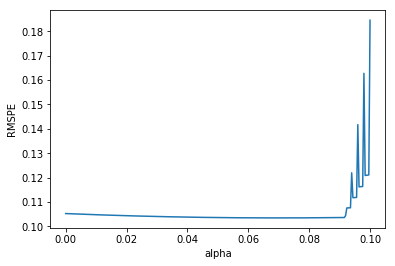

The variable to be selected for the alpha is:  0.06987951807228916
The final accuracy on the test set is:  0.09868613781369324


In [144]:
# Defining the training set 

training_filter = (Sales_Store_merged["Store"] == 3) & (Sales_Store_merged["Date"] < "2013-02-02")
Sales_Store_merged_Ridge_training = Sales_Store_merged_Ridge[training_filter]
Sales_Store_merged_Ridge_training.head()

# Defining the validation set 

validation_filter = (Sales_Store_merged["Store"] == 3) & ((Sales_Store_merged["Date"] >= "2013-02-02") & (Sales_Store_merged["Date"] <= "2013-02-12"))
Sales_Store_merged_Ridge_validation = Sales_Store_merged_Ridge[validation_filter]
Sales_Store_merged_Ridge_validation.head()

# Defining the testing set 

testing_filter = (Sales_Store_merged["Store"] == 3) & ((Sales_Store_merged["Date"] >= "2013-02-12") & (Sales_Store_merged["Date"] <= "2013-02-18"))
Sales_Store_merged_Ridge_testing = Sales_Store_merged_Ridge[testing_filter]
Sales_Store_merged_Ridge_testing.head()

# Running the normal model, ie the non-regularized model, to find the starting parameters 

model_ = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit()
start_params=model_.params

# Iterating over a range of alphas to come up with the alpha that gives us the lowest RMSPE. After a few trials we concluded that the interval [0, 0.10] is the one that 
# includes the value of alpha that minimizes the RMSPE of our model

RMSPE_list_ = []
alpha_range = np.linspace(0, 0.10, num=250)

for alpha_ in alpha_range:
  model_ = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit()
  start_params=model_.params
  model_final_=ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit_regularized(start_params=start_params, alpha=alpha_, L1_wt=1)
  Prediction_final=np.exp(model_final_.predict(Sales_Store_merged_Ridge_validation))
  ## Getting the RMSPE
  Actual_final=Sales_Store_merged_Ridge_validation["Sales"]
  RMSPE_final= (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5
  RMSPE_list_.append(RMSPE_final)
  # print(RMSPE_final)

plt.plot(alpha_range, RMSPE_list_)
plt.xlabel("alpha")
plt.ylabel("RMSPE")
plt.show()

RMSPE_min = RMSPE_list_.index(min(RMSPE_list_))
print('The variable to be selected for the alpha is: ', alpha_range[RMSPE_min])

#####RMSPE over different intervals
# -------RMSPE--------|--------Interval-------
# 0.06827309236947787 | (-1,1)
# 0.07148594377510031 | (-1, 0.15)
# 0.06987951807228915 | (-0.2, 0.15)
# 0.06987951807228915 | (0, 0.15)
# 0.06987951807228916 | (0, 0.10)

# Now that we found the alpha that minimizes the RMSPE we run the model using Ridge regression on the training set
model_ = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit()
start_params=model_.params
model_final_=ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit_regularized(start_params=start_params, alpha=0.06987951807228916, L1_wt=1)
Prediction_final=np.exp(model_final_.predict(Sales_Store_merged_Ridge_validation))
## Getting the RMSPE
Actual_final=Sales_Store_merged_Ridge_validation["Sales"]
RMSPE_final= (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5

# Selecting and running the final model 

model_final = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit()
Actual_final=Sales_Store_merged_Ridge_testing["Sales"]
Prediction_final=np.exp(model_final.predict(Sales_Store_merged_Ridge_testing))

# Reporting the accuracy on the test set
RMSPE_final=rmspe(Prediction_final, Actual_final)
print('The final accuracy on the test set is: ', RMSPE_final)

# RMSPE_list_ = []
# alpha_range = np.linspace(0, 10, num=250)

# for alpha_ in alpha_range:
#   model_ = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_validation).fit()
#   start_params=model_.params
#   model_final_=ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_validation).fit_regularized(start_params=start_params, alpha=alpha_, L1_wt=1)
#   Prediction_final=np.exp(model_final_.predict(Sales_Store_merged_Ridge_validation))
#   ## Getting the RMSPE
#   Actual_final=Sales_Store_merged_Ridge_validation["Sales"]
#   RMSPE_final= (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5
#   RMSPE_list_.append(RMSPE_final)
#   # print(RMSPE_final)

# plt.plot(alpha_range, RMSPE_list_)
# plt.xlabel("alpha")
# plt.ylabel("RMSPE")
# plt.show()

# RMSPE_min = RMSPE_list_.index(min(RMSPE_list_))
# print('The variable to be selected for the alpha is: ', alpha_range[RMSPE_min])

In [0]:
# # Make a multiple-histogram of data-sets with different length.
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
# ax3.hist(x_multi, n_bins, histtype='bar')
# ax3.set_title('different sample sizes')

# fig.tight_layout()
# plt.show()

##Q7. [13 points]
###[Standardization in ridge regression]
The previous model gives an okay solution. However, one thing to notice is that the scale of variations could also affect $\beta$ values, which can cause factors to be discriminated simply based on whether the values are small or large. In addition, we do not want $\beta_0$ to be penalized.

As a result, people usually standardize the variables. Especially, for Ridge regression, a common practice is to do the following:

**On the training set:**

1. Standardize each independent variable using 

$$\frac{x_k-\bar{x_k}}{s_{x_k}}$$

where $\bar{x}$ and $s_x$ are the mean and the standard deviation of variable $x_k$ on the training set. 


2. Re-center the dependent variable using 

$$y-\bar{y}$$

where $\bar{y}$ is the mean of $y$ on the training set.

This allows us to tease out the impact of $\beta_0$ in the regulation

3. Regress the de-centered depedent variable on the standardized independent variables without intercept. [you can simply use "y~x1+x2-1" to not estimate the intercept]

**On the validation and testing set:**

When you do the prediction on the validation set, we will have

$$\hat{y}=\bar{y}+\sum \hat{\beta_k} {\frac{x-\bar{x_k}}{s_{x_k}}}$$

where $\bar{y}$ is the mean of $y$ on the **training set**, $\bar{x_k}$ is the mean of $x_k$ on the **training set**, while $s_{x_k}$ is the standard deviation of $x_k$ on the **training set**.



* Use this method to re-do Q6. 
* Determine the best model based on Q6 and Q7. Report the accuracy on the test set.



In [0]:
#Original model
model1 = ols(formula="np.log(Sales)~np.log(Customers)+Customers",data=Sales_Store_merged_Ridge_training).fit()
prediction1 = np.exp(model1.predict())
# prediction1

In [147]:
#demean logSale
logSale_mean=np.mean(np.log(Sales_Store_merged_Ridge_training["Sales"]))
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(logSales_demean=lambda x:np.log(x.Sales)-logSale_mean)

#standardize the independent variables
logCustomers_mean=np.mean(np.log(Sales_Store_merged_Ridge_training["Customers"]))
logCustomers_Std=np.std(np.log(Sales_Store_merged_Ridge_training["Customers"]))
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(logCustomers_standardized=lambda x:(np.log(x.Customers)-logCustomers_mean)/logCustomers_Std)

Customers_mean=np.mean(Sales_Store_merged_Ridge_training["Customers"])
Customers_Std=np.std(Sales_Store_merged_Ridge_training["Customers"])
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(Customers_standardized=lambda x:(x.Customers-Customers_mean)/Customers_Std)

Sales_Store_merged_Ridge_training.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,logSales_demean,logCustomers_standardized,Customers_standardized
981532,3,5,2013-02-01,6725,806,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0.095090,0.721619,0.686587
982647,3,4,2013-01-31,5682,648,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",-0.073439,-0.313111,-0.412467
983762,3,3,2013-01-30,4920,647,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",-0.217434,-0.320435,-0.419423
984877,3,2,2013-01-29,5375,711,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",-0.128984,0.126885,0.025763
985992,3,1,2013-01-28,5352,722,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",-0.133272,0.199692,0.102279


In [0]:
model2=ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit()
# prediction2=np.exp(model2.predict()+logSale_mean)
# prediction2-prediction1

# We need to follow the same procedure for the validation set:

#demean logSale
logSale_mean=np.mean(np.log(Sales_Store_merged_Ridge_validation["Sales"]))
Sales_Store_merged_Ridge_validation=Sales_Store_merged_Ridge_validation.assign(logSales_demean=lambda x:np.log(x.Sales)-logSale_mean)

#standardize the independent variables
logCustomers_mean=np.mean(np.log(Sales_Store_merged_Ridge_validation["Customers"]))
logCustomers_Std=np.std(np.log(Sales_Store_merged_Ridge_validation["Customers"]))
Sales_Store_merged_Ridge_validation=Sales_Store_merged_Ridge_validation.assign(logCustomers_standardized=lambda x:(np.log(x.Customers)-logCustomers_mean)/logCustomers_Std)

Customers_mean=np.mean(Sales_Store_merged_Ridge_validation["Customers"])
Customers_Std=np.std(Sales_Store_merged_Ridge_validation["Customers"])
Sales_Store_merged_Ridge_validation=Sales_Store_merged_Ridge_validation.assign(Customers_standardized=lambda x:(x.Customers-Customers_mean)/Customers_Std)

# Now we can predict 

Prediction_final=np.exp(model2.predict(Sales_Store_merged_Ridge_validation)+logSale_mean)
## Getting the RMSPE
Actual_final=Sales_Store_merged_Ridge_validation["Sales"]
RMSPE_final= (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5

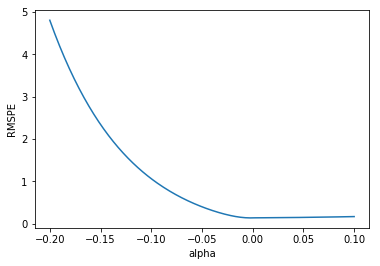

The variable to be selected for the alpha is:  -0.0012048192771084154
The final accuracy on the test set is:  0.04526045238754683
This model has better performance (predictive power) than the one of Q6, since the final accuracy on the test set for the model of Q6 is:  0.09868613781369324       (=RMSPE_model_Q6), and the the performance of this model is 0.04526045238754683 (=RMSPE_model_Q7). We know that the smallest the RMSPE the higher the accuracy of the       regression model, so the better the model.


In [149]:
#demean logSale
logSale_mean=np.mean(np.log(Sales_Store_merged_Ridge_training["Sales"]))
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(logSales_demean=lambda x:np.log(x.Sales)-logSale_mean)

#standardize the independent variables
logCustomers_mean=np.mean(np.log(Sales_Store_merged_Ridge_training["Customers"]))
logCustomers_Std=np.std(np.log(Sales_Store_merged_Ridge_training["Customers"]))
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(logCustomers_standardized=lambda x:(np.log(x.Customers)-logCustomers_mean)/logCustomers_Std)

Customers_mean=np.mean(Sales_Store_merged_Ridge_training["Customers"])
Customers_Std=np.std(Sales_Store_merged_Ridge_training["Customers"])
Sales_Store_merged_Ridge_training=Sales_Store_merged_Ridge_training.assign(Customers_standardized=lambda x:(x.Customers-Customers_mean)/Customers_Std)

# Running the normal model, ie the non-regularized model, to find the starting parameters 

model_ = ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit()
start_params=model_.params

# Iterating over a range of alphas to come up with the alpha that gives us the lowest RMSPE. After a few trials we concluded that the interval [0, 0.10] is the one that 
# includes the value of alpha that minimizes the RMSPE of our model

RMSPE_list_ = []
alpha_range = np.linspace(-0.2, 0.10, num=250)

for alpha_ in alpha_range:
  model_ = ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit()
  start_params=model_.params
  model_final_=ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit_regularized(start_params=start_params, alpha=alpha_, L1_wt=1)
  Prediction_final=np.exp(model_final_.predict(Sales_Store_merged_Ridge_validation)+logSale_mean)
  ## Getting the RMSPE
  Actual_final=Sales_Store_merged_Ridge_validation["Sales"]
  RMSPE_final= (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5
  RMSPE_list_.append(RMSPE_final)
  # print(RMSPE_final)

plt.plot(alpha_range, RMSPE_list_)
plt.xlabel("alpha")
plt.ylabel("RMSPE")
plt.show()

RMSPE_min = RMSPE_list_.index(min(RMSPE_list_))
print('The variable to be selected for the alpha is: ', alpha_range[RMSPE_min])

#####RMSPE over different intervals
# -------RMSPE--------|--------Interval-------
# 0.06827309236947787 | (-1,1)
# 0.07148594377510031 | (-1, 0.15)
# 0.06987951807228915 | (-0.2, 0.15)
# 0.06987951807228915 | (0, 0.15)
# 0.06987951807228916 | (0, 0.10)

# Now that we found the alpha that minimizes the RMSPE we run the model using Ridge regression on the training set
model_ = ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit()
start_params=model_.params
model_final_= ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit_regularized(start_params=start_params, alpha=0.06987951807228916, L1_wt=1)
Prediction_final=np.exp(model_final_.predict(Sales_Store_merged_Ridge_validation)+logSale_mean)
## Getting the RMSPE
Actual_final = Sales_Store_merged_Ridge_validation["Sales"]
RMSPE_final = (np.mean(((Prediction_final-Actual_final)/Actual_final)**2))**0.5

# We need to follow the same procedure for the validation set:

#demean logSale
logSale_mean=np.mean(np.log(Sales_Store_merged_Ridge_testing["Sales"]))
Sales_Store_merged_Ridge_testing=Sales_Store_merged_Ridge_testing.assign(logSales_demean=lambda x:np.log(x.Sales)-logSale_mean)

#standardize the independent variables
logCustomers_mean=np.mean(np.log(Sales_Store_merged_Ridge_testing["Customers"]))
logCustomers_Std=np.std(np.log(Sales_Store_merged_Ridge_testing["Customers"]))
Sales_Store_merged_Ridge_testing=Sales_Store_merged_Ridge_testing.assign(logCustomers_standardized=lambda x:(np.log(x.Customers)-logCustomers_mean)/logCustomers_Std)

Customers_mean=np.mean(Sales_Store_merged_Ridge_testing["Customers"])
Customers_Std=np.std(Sales_Store_merged_Ridge_testing["Customers"])
Sales_Store_merged_Ridge_testing=Sales_Store_merged_Ridge_testing.assign(Customers_standardized=lambda x:(x.Customers-Customers_mean)/Customers_Std)

# Now we can predict 

# Selecting and running the final model 
model_final = ols(formula="logSales_demean~logCustomers_standardized+Customers_standardized-1",data=Sales_Store_merged_Ridge_training).fit()
Actual_final=Sales_Store_merged_Ridge_testing["Sales"]
Prediction_final=np.exp(model_final.predict(Sales_Store_merged_Ridge_testing)+logSale_mean)

# Reporting the accuracy on the test set
RMSPE_final=rmspe(Prediction_final, Actual_final)
print('The final accuracy on the test set is: ', RMSPE_final)

print('This model has better performance (predictive power) than the one of Q6, since the final accuracy on the test set for the model of Q6 is:  0.09868613781369324 \
      (=RMSPE_model_Q6), and the the performance of this model is 0.04526045238754683 (=RMSPE_model_Q7). We know that the smallest the RMSPE the higher the accuracy of the \
      regression model, so the better the model.')

##Q*. Bonus question [3 points]

Do the task in Q4 but with the following factors with the help of `for` loop

* Promo
* SchoolHoliday
* C(Store)
* C(DayOfWeek)
* C(Store)#np.log(Customers)
* C(Month)
* C(Year)
* C(StateHoliday)



In [150]:
list_ = ['Promo', 'SchoolHoliday', 'C(Store)', 'C(DayOfWeek)', 'C(Store)*np.log(Customers)', 'C(Date.dt.month)', 'C(Date.dt.year)', 'C(StateHoliday)']
RMSPE_list_ = []
RMSPE_min_list = []

for item_list_ in list_:
  model_=ols(formula="np.log(Sales)~np.log(Customers)"+"+"+item_list_ ,data=Sales_Store_merged_training).fit()
  Actual=Sales_Store_merged_validation["Sales"]
  Prediction_=np.exp(model_.predict(Sales_Store_merged_validation))
  RMSPE_=rmspe(Prediction_, Actual)
  RMSPE_list_.append(RMSPE_)
  # print(RMSPE_)
  RMSPE_max = RMSPE_list_.index(max(RMSPE_list_))
  RMSPE_min = RMSPE_list_.index(min(RMSPE_list_))
  RMSPE_min_list.append(RMSPE_min)
  list_.remove(list_[RMSPE_max])

print('The variable to be selected for model selection is: ', [list_[i] for i in RMSPE_min_list])

# We conclude that 'SchoolHoliday', 'C(DayOfWeek)', 'C(Store)*np.log(Customers)', 'C(Date.dt.month)' are the new variables that should be selected in the model selection, since 
# the RMSPEs we obtain when we include 'SchoolHoliday', 'C(DayOfWeek)', 'C(Store)*np.log(Customers)', 'C(Date.dt.month)' in our model are the minimal one, between the others we
# obtain for 'Promo', 'SchoolHoliday', 'C(Store)', 'C(Date.dt.year)', 'C(StateHoliday)', respectively.

The variable to be selected for model selection is:  ['C(DayOfWeek)', 'C(Store)*np.log(Customers)', 'C(Date.dt.month)', 'C(Date.dt.month)']
